# **Supervised Learning - Autism Dataset for Toddlers**

## Autism Spectrum Disorder (ASD) Diagnosis

# **Introduction**

# The Dataset being used is adapted from the Kaggle's Autism Dataset for Toddlers page, which contains 1054 reported cases , each with 19 attributes. The most important ones to look at is, namely, the Q-chat-score, that is , the aggregate of the results from the 10-question questionaire, that corresponds to influential features to be utilised for further analysis especially in determining autistic traits , each one corresponding also to an binary attribute, and other labeled attributes, such as Sex,Ethnicity,Jaundice,Family_mem_with_ASD,Who completed the test, and the "Class/ASD Traits ", which is derived from the Q-Chat Score. The remaining one that is numeric , is the case numeber, a unique identifier for each row of results

# The goal of this project is to improve the classification of the ASD traits, given a whole dataset of diagnosis based on certain features evaluated on the questionnaires, and evaluate their distribution by other parallel factors that are labeled, such as Sex,Ethnicity,Jaundice,Family_mem_with_ASD,Who completed the test, and the "Class/ASD Traits "

# The solution to this problem is a supervised learning model, which will be trained using the dataset mentioned above. The model will be trained using the training set, and then evaluated using the test set. The model will be evaluated using the accuracy metric, which is the percentage of diagnosis that are correctly done / probability of a certain diagnose is correctly done , taking into account all the labeled factors.

---

This project was made possible by:

| Name | Email |
|-|-|
| André Silva | up202108724@up.pt |
| Bernardo Pinto | up202108842@up.pt |
| Francisco Sousa | up202108838@up.pt |
|---|---|
| Group | T10 - G104 |

### Importing libraries

Throughout the study, many libraries were incrementally added, thus, it is important to install them all, which can be done by running the following command in the terminal (make sure you are in the project's root directory):

```bash
pip install -r requirements.txt
```

Then, we can import the libraries we will use in this project.

Note that we also had disabled the warnings, to make the notebook cleaner.

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
from sklearn.preprocessing import LabelEncoder
#import pycaret


In [73]:
#import pandas as pd

dataframe = pd.read_csv("./Autism_dataset.csv")
dataframe.head()

,Case_No,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,Age_Mons,Qchat-10-Score,Sex,Ethnicity,Jaundice,Family_mem_with_ASD,Who completed the test,Class/ASD Traits
0,1,0,0,0,0,0,0,1,1,0,1,28,3,f,middle eastern,yes,no,family member,No
1,2,1,1,0,0,0,1,1,0,0,0,36,4,m,White European,yes,no,family member,Yes
2,3,1,0,0,0,0,0,1,1,0,1,36,4,m,middle eastern,yes,no,family member,Yes
3,4,1,1,1,1,1,1,1,1,1,1,24,10,m,Hispanic,no,no,family member,Yes
4,5,1,1,0,1,1,1,1,1,1,1,20,9,f,White European,no,yes,family member,Yes


# Data pre-processing



In [74]:
dataframe.describe()


,Case_No,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,Age_Mons,Qchat-10-Score
count,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000
mean,527.500000,0.563567,0.448767,0.401328,0.512334,0.524668,0.576850,0.649905,0.459203,0.489564,0.586338,27.867173,5.212524
std,304.407895,0.496178,0.497604,0.490400,0.500085,0.499628,0.494293,0.477226,0.498569,0.500128,0.492723,7.980354,2.907304
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000
25%,264.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.000000,3.000000
50%,527.500000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,30.000000,5.000000
75%,790.750000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,36.000000,8.000000
max,1054.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,36.000000,10.000000


In [75]:
dataframe.isna().any()

Case_No                   False
A1                        False
A2                        False
A3                        False
A4                        False
A5                        False
A6                        False
A7                        False
A8                        False
A9                        False
A10                       False
Age_Mons                  False
Qchat-10-Score            False
Sex                       False
Ethnicity                 False
Jaundice                  False
Family_mem_with_ASD       False
Who completed the test    False
Class/ASD Traits          False
dtype: bool

In [76]:
dataframe= dataframe.drop(columns=['Case_No','Qchat-10-Score'])
print(dataframe['Class/ASD Traits'].head())

0     No
1    Yes
2    Yes
3    Yes
4    Yes
Name: Class/ASD Traits, dtype: object


In [77]:

encoder= LabelEncoder()

binary_cols= ["Sex", "Jaundice", "Family_mem_with_ASD" , "Class/ASD Traits"]

for binary_atribute in binary_cols:
    dataframe[binary_atribute] = encoder.fit_transform(dataframe[binary_atribute])

dataframe["Who completed the test"]= dataframe["Who completed the test"].replace("Health care professional","Health Care Professional")

#print(dataframe["Who completed the test"].unique())

categorical_cols = ["Ethnicity", "Who completed the test"]

# Applying one-hot encoding to categorical columns
one_hot_encoded = pd.get_dummies(dataframe[categorical_cols])

# Concatenating one-hot encoded columns with the original dataframe
dataframe_encoded = pd.concat([dataframe, one_hot_encoded], axis=1)

# Dropping the original categorical columns
dataframe_encoded.drop(categorical_cols, axis=1, inplace=True)

before_one_hot = dataframe
# Displaying the resulting dataframe
np.unique(dataframe.iloc[:,17:18])



array([], dtype=float64)

# Dataset Analysis

Index(['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'Age_Mons',
       'Sex', 'Jaundice', 'Family_mem_with_ASD', 'Class/ASD Traits',
       'Ethnicity_Hispanic', 'Ethnicity_Latino', 'Ethnicity_Native Indian',
       'Ethnicity_Others', 'Ethnicity_Pacifica', 'Ethnicity_White European',
       'Ethnicity_asian', 'Ethnicity_black', 'Ethnicity_middle eastern',
       'Ethnicity_mixed', 'Ethnicity_south asian',
       'Who completed the test_Health Care Professional',
       'Who completed the test_Others', 'Who completed the test_Self',
       'Who completed the test_family member'],
      dtype='object')


C:\Users\Andre Silva\AppData\Local\Temp\ipykernel_3900\3490233393.py:56: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_df = df.groupby(['Age_Binned', 'Group']).size().unstack(fill_value=0)


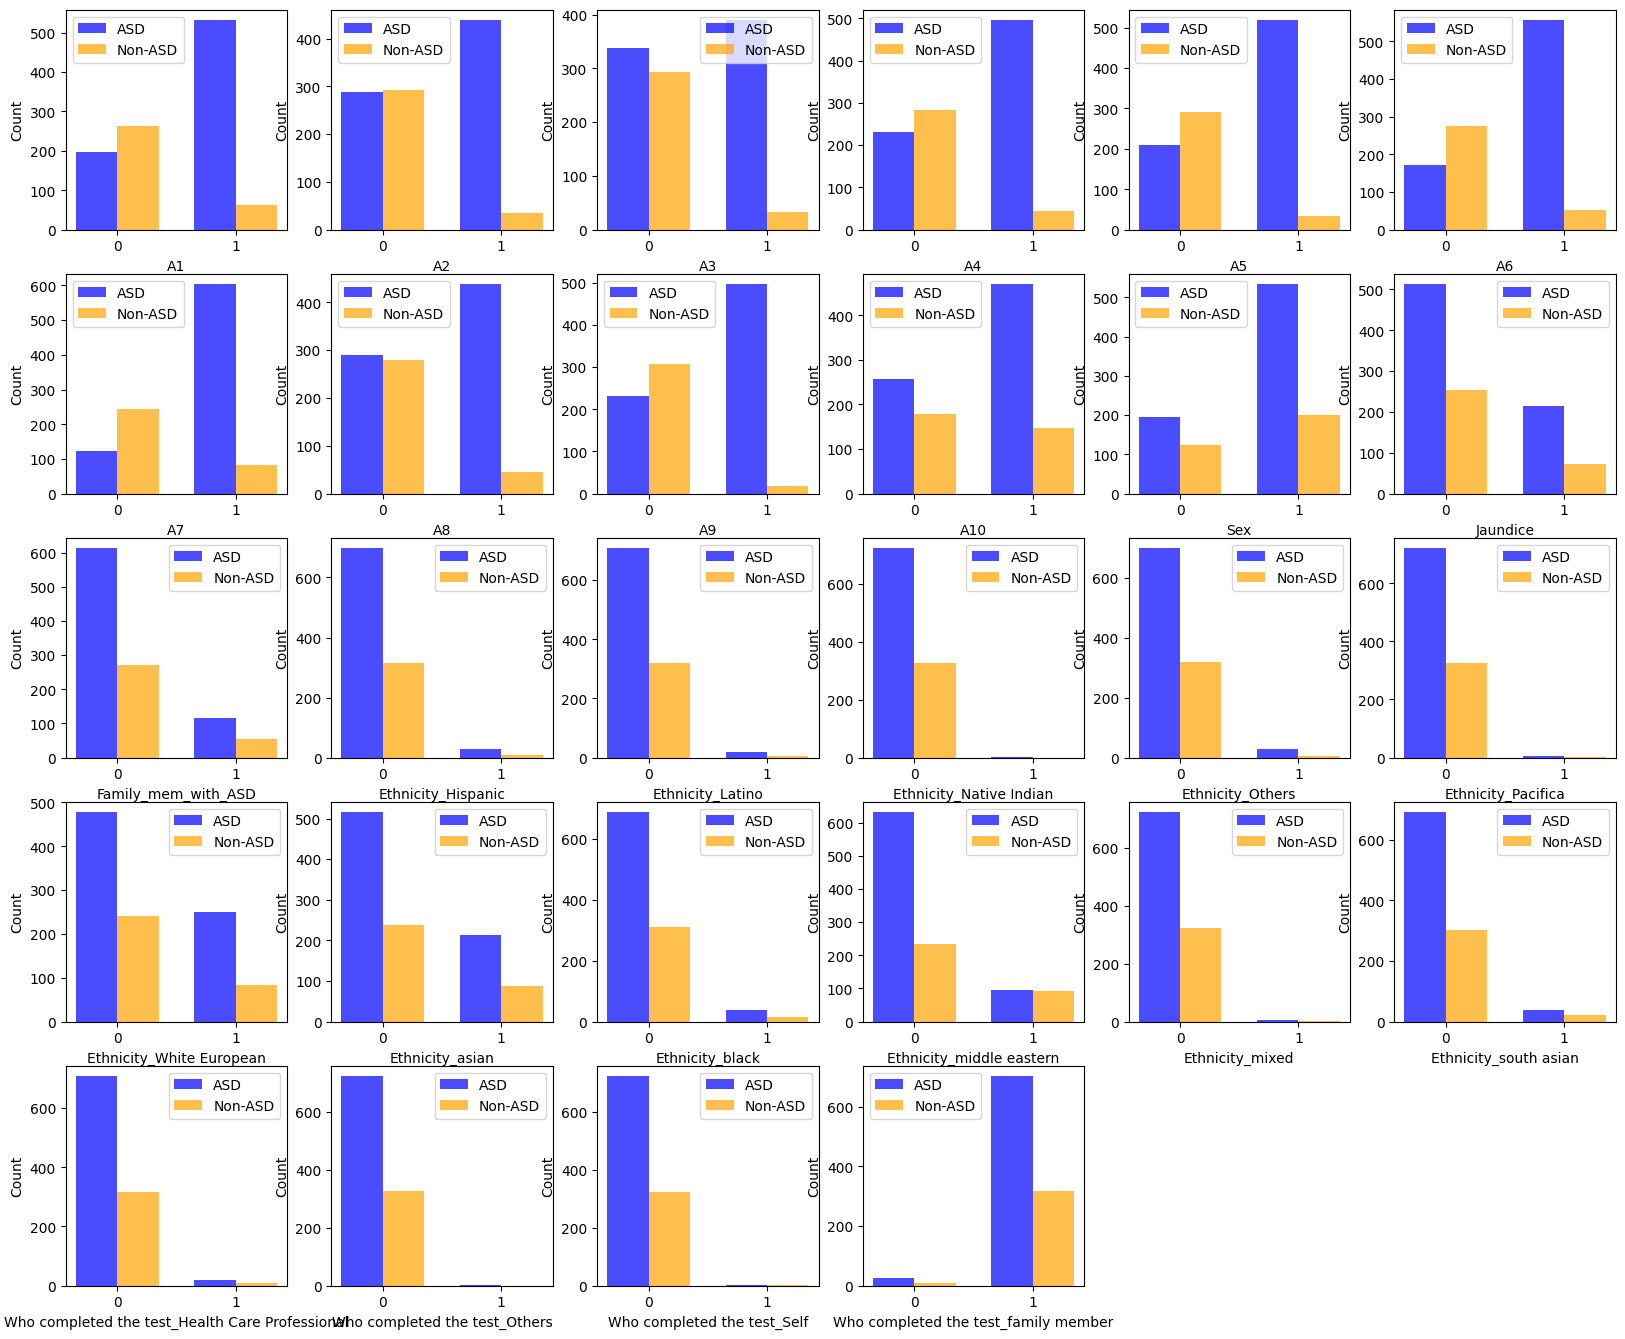

<Figure size 1200x600 with 0 Axes>

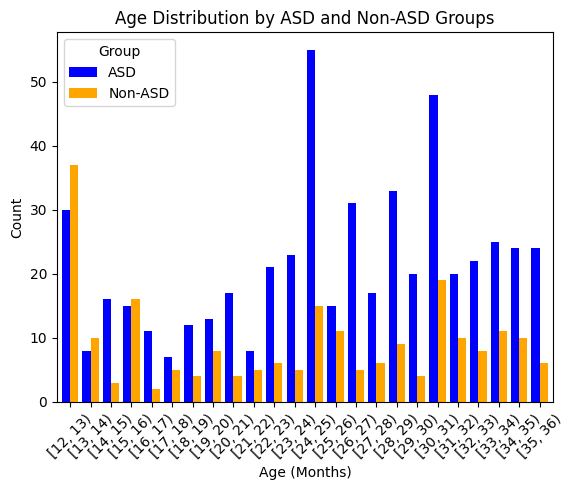

<Figure size 640x480 with 0 Axes>

In [78]:
plt.figure(figsize=(20, 20))

# Assuming dataframe_encoded is your dataframe after one-hot encoding

# Splitting the dataframe based on the target variable
df1 = dataframe_encoded[dataframe_encoded['Class/ASD Traits'] == 1].drop(columns=['Class/ASD Traits'])
df2 = dataframe_encoded[dataframe_encoded['Class/ASD Traits'] == 0].drop(columns=['Class/ASD Traits'])
print(dataframe_encoded.columns)

# Plotting the distributions
num_columns = len(df1.columns)
plot_index = 1

for i in range(num_columns):
    column_name = df1.columns[i]
    plt.subplot(6, 6, plot_index)
    
    if column_name == 'Age_Mons':
        continue
    else:
        # Count occurrences of 0s and 1s
        count_0_1_df1 = df1[column_name].value_counts().sort_index()
        count_0_1_df2 = df2[column_name].value_counts().sort_index()
        
        # Create a DataFrame for plotting
        plot_data = pd.DataFrame({
            'Value': [0, 1],
            'ASD': count_0_1_df1,
            'Non-ASD': count_0_1_df2
        }).fillna(0)  # Fill NaNs with 0
        
        # Plot bars
        bar_width = 0.35
        plt.bar(plot_data['Value'] - bar_width/2, plot_data['ASD'], width=bar_width, label='ASD', color='blue', alpha=0.7)
        plt.bar(plot_data['Value'] + bar_width/2, plot_data['Non-ASD'], width=bar_width, label='Non-ASD', color='orange', alpha=0.7)
        plt.xlabel(column_name)
        plt.ylabel('Count')
        plt.xticks([0, 1])
    
    plt.legend()
    plot_index += 1


# Special plot for continuous variable 'age-months'
df1['Group'] = 'ASD'
df2['Group'] = 'Non-ASD'
df = pd.concat([df1, df2])
        

binwidth = 1
age_min = int(df['Age_Mons'].min())
age_max = int(df['Age_Mons'].max()) + binwidth
bins = range(age_min, age_max, binwidth)
df['Age_Binned'] = pd.cut(df['Age_Mons'], bins, right=False, include_lowest=True)
# Count occurrences within each bin and group
count_df = df.groupby(['Age_Binned', 'Group']).size().unstack(fill_value=0)

# Plot the data
plt.figure(figsize=(12, 6))
count_df.plot(kind='bar', width=0.8, color=['blue', 'orange'])
plt.xlabel('Age (Months)')
plt.ylabel('Count')
plt.title('Age Distribution by ASD and Non-ASD Groups')
plt.legend(title='Group')
plt.xticks(rotation=45)
plt.show()
df1.drop(columns=['Group'], inplace=True)
df2.drop(columns=['Group'], inplace=True)
plt.tight_layout()
plt.show()

In [1]:
def cramers_v(x, y):
    """Calculate Cramér's V statistic for categorical-categorical association."""
    confusion_matrix = pd.crosstab(x, y)
    chi2 = stat.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    return np.sqrt(chi2 / (n * (min(confusion_matrix.shape) - 1)))

def calculate_correlations(dataframe, target_column):
    correlations = {}
    for column in dataframe.columns:
        if column == target_column:
            continue
        if dataframe[column].nunique() == 2:  # Binary
            if dataframe[target_column].nunique() == 2:
                # Both are binary -> Cramér's V
                corr = cramers_v(dataframe[column], dataframe[target_column])
            else:
                # Binary - Continuous -> Point Biserial
                corr, _ = stat.pointbiserialr(dataframe[column], dataframe[target_column])
        elif dataframe[target_column].nunique() == 2:
            # Continuous - Binary -> Point Biserial
            corr, _ = stat.pointbiserialr(dataframe[target_column], dataframe[column])
        else:
            # Continuous - Continuous -> Pearson's
            corr = dataframe[column].corr(dataframe[target_column])
        correlations[column] = corr
    return correlations
# a_function(int a.bar(), bool b.foo())
# Assuming dataframe_encoded is your dataframe
target_column = 'Class/ASD Traits'

for column in before_one_hot.columns:
    if before_one_hot[column].dtype == 'object':
        before_one_hot[column] = encoder.fit_transform(before_one_hot[column])

#print(before_one_hot["Ethnicity"])

# Check if the target column is in the dataframe's columns

if target_column in before_one_hot.columns:
    # Calculate correlations
    correlations = calculate_correlations(before_one_hot, target_column)
    
    # Convert to DataFrame for heatmap
    correlation_df = pd.DataFrame.from_dict(correlations, orient='index', columns=[target_column])
    correlation_df = correlation_df.sort_values(by=target_column, ascending=False)
    
    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_df, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f'Correlations with {target_column}')
    plt.show()
else:
    print(f"Column '{target_column}' not found in the dataframe.")
    

NameError: name 'before_one_hot' is not defined